# k-Nearest Neighbors

#### The following few portions will be referencing resources mainly from Killian Weinberger's materials from CS4780 [1].

k-Nearest Neighbors is a simple algorithm that determines a test input's label based on its nearest k neighbors (from the training input). 

Assumptions:
- For inputs with similar features, you are going to have similar outputs. Nearby neighbors are similar to each other. This may not always be the case.
    Example: A large flying insect can be misclassified as a bird.

    

For a given test point $\mathbf{x}$, the set of k nearest neighbors of $\mathbf{x}$ ($S_\mathbf{x}$) is defined as:

$$
S_\mathbf{x} \subseteq \text{training dataset $D$ such that } |S_\mathbf{x}| = k 
$$

$$
\text{ and $\forall$ other points } (x^{'}, y^{'}) \text{ in $D \setminus S_\mathbf{x}$,}
$$

$$
\text{dist}(\mathbf{x},\mathbf{x}')\ge\max_{(\mathbf{x}'',y'')\in S_\mathbf{x}} \text{dist}(\mathbf{x},\mathbf{x}''),$$

In other words, for every point in the $D$ that is not in the set of k nearest neighbors $S_x$, the distance between any one of them has to be at least as far away from $x$ as the furthest point selected to be in $S_x$ [1].

The hypothesis using k-NN $h()$ can be defined as the following:

$$
h(\mathbf{x})=\text{mode}(\{y'':(\mathbf{x}'',y'')\in S_\mathbf{x}\}),
$$

In other words, for every pair of data point $(x^{"}, y^{"})$ belonging to our set of k-NN $S_x$, the hypothesis/classifier $h(x)$ picks the label with the highest occurrence(mode)[1].

k-NN can be used as a classification or regression algorithm. For regression, the output is determined by the average of the outputs of the neighbors [2].

## How do we measure closeness?

The Minkowski distance is commonly used as a distance metric in k-NN. It is given as:

$$
\text{dist}(\mathbf{x},\mathbf{z})=\left(\sum_{r=1}^d |x_r-z_r|^p\right)^\frac {1}{p}
$$

It is typically used with $p = 1$ (Manhattan) or $p = 2$ (Euclidean). In the case where $p\to \infty$, the Chebyshev distance is obtained. 

Other than the Minkowski distance, cosine similarity is also used as a similarity metric.

#### Some of the following code were taken and adapted from ML-From-Scratch repo by Erik Linder-Norén [3]

[Text(0, 0.5, 'Sepal Width'), Text(0.5, 0, 'Sepal length')]

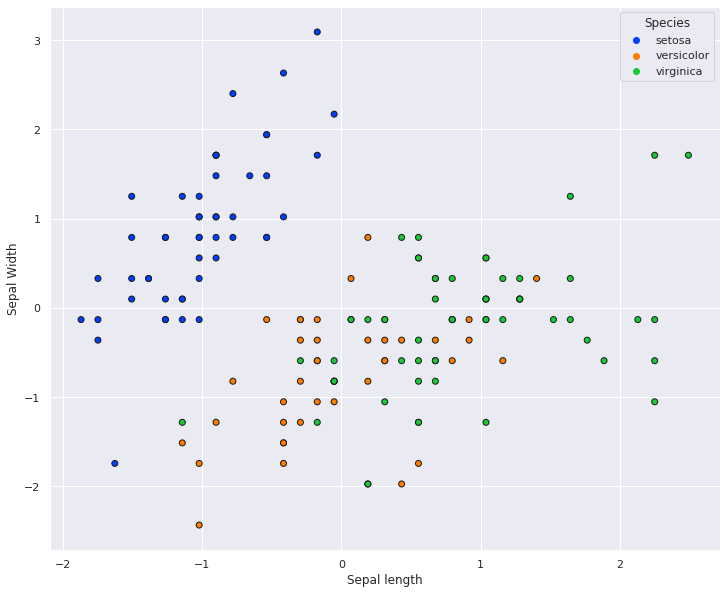

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

def standardize(X):
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std

iris = datasets.load_iris()
X = standardize(iris.data[:, :2])
y = iris.target
sns.set(style = "darkgrid")

#Visualise data with 2 features
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, edgecolor='k', linewidth=1, palette="bright")
ax.legend(ax.legend_.legendHandles, iris.target_names, title='Species')

ax.set(xlabel='Sepal length', ylabel='Sepal Width')

In [2]:
import math

class KNN():
    
    def __init__(self, k=3):
        self.k = k
        
    def calDist(self, test, x, p=2):
        distance = 0
        
        for i in range(len(x)):
            if p == 1:
                """ Calculate Manhattan distance"""
                distance += abs(x[i] - test[i])
            elif p == 2:
                """ Calculate Euclidean distance"""
                distance += pow((x[i] - test[i]), 2)
                distance = math.sqrt(distance)
            else:
                raise Exception('Enter p = 1 or 2')

        return distance
    
    def _vote(self, neighbor_labels):
        """ Return the most common class among the neighbor samples """
        counts = np.bincount(neighbor_labels.astype('int'))
        return counts.argmax()
    
    def predict(self, X_test, X_train, y_train, p=2):
        y_pred = np.empty(X_test.shape[0])
        # Determine the class of each sample
        for i, test_sample in enumerate(X_test):
            # Sort the training samples by their distance to the test sample and get the K nearest
            idx = np.argsort([self.calDist(test_sample, x, p) for x in X_train])[:self.k]
            # Extract the labels of the K nearest neighboring training samples
            k_nearest_neighbors = np.array([y_train[i] for i in idx])
            # Label sample as the most common class label
            y_pred[i] = self._vote(k_nearest_neighbors)

        return y_pred
    
    def calAccuracy(self, y_pred, y_test):
        acc = np.sum(y_pred == y_test, axis=0) / len(y_test)
        
        return acc

In [3]:
def shuffle_data(X, y, seed=None):
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

def data_split(X, y, split_size=0.15, shuffle=True, seed=None):
    if shuffle:
        X, y = shuffle_data(X, y, seed)
        
    split_i = len(y) - int(len(y) // (1 / split_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test

#Split into training, validation, testing
X_train_val, X_test, y_train_val, y_test = data_split(X, y, seed=123)
X_train, X_val, y_train, y_val = data_split(X_train_val, y_train_val, seed=123)

print(f'Training Samples: {X_train.shape[0]}')
print(f'Validation Samples: {X_val.shape[0]}')
print(f'Testing Samples: {X_test.shape[0]}')

Training Samples: 109
Validation Samples: 19
Testing Samples: 22


[Text(0, 0.5, 'Validation Accuracy'), Text(0.5, 0, 'k')]

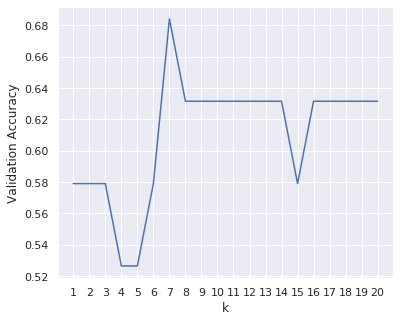

In [4]:
accuracies=[]
for i in range(1,21):
    clf = KNN(i)
    y_pred = clf.predict(X_val, X_train, y_train, p=2)

    accuracy = clf.calAccuracy(y_pred, y_val)
    accuracies.append(accuracy)

fig, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(x=range(1,21), y=accuracies)
ax.set_xticks(range(1, 21))
ax.set(xlabel='k', ylabel='Validation Accuracy')

In [5]:
# Set k
k = 7

[Text(0, 0.5, 'Sepal Width'), Text(0.5, 0, 'Sepal length')]

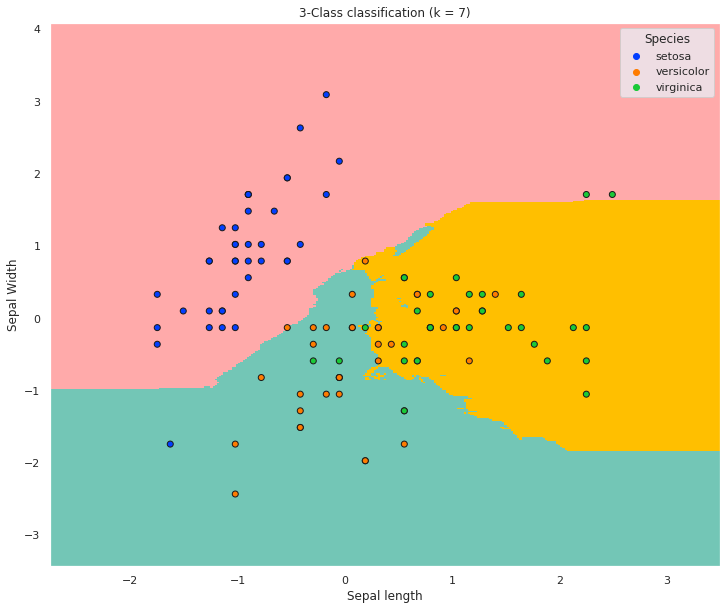

In [6]:
from matplotlib.colors import ListedColormap

# Step size in the mesh
h = .02

# Plot the decision boundary. 
# For that, we will assign a color to each point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()], X_train, y_train, p=2)

# Create color map
cmap_light = ListedColormap(['#FFAAAA', '#73C6B6', '#FFBF00'])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig, ax = plt.subplots(figsize=(12, 10))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot training points
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, edgecolor='k', linewidth=1, palette="bright")
ax.legend(ax.legend_.legendHandles, iris.target_names, title='Species')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_title("3-Class classification (k = %i)"%k)
ax.set(xlabel='Sepal length', ylabel='Sepal Width')

In [7]:
y_pred = clf.predict(X_test, X_train, y_train, p=2)
accuracy = clf.calAccuracy(y_pred, y_test)
print(f'Testing Accuracy: {accuracy:.3f}')

Testing Accuracy: 0.864


### References
[1] CS4780/CS5780: Machine Learning for Intelligent Systems. Killian Weinberger, 2017.  https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote02_kNN.html

[2] k-nearest neighbors algorithm. https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

[3] ML-From-Scratch. Erik Linder-Norén. https://github.com/eriklindernoren/ML-From-Scratch